# Graph Neural Networks

<img src="https://miro.medium.com/max/1400/1*ZMIwWfua5zG_C4hcN_4I_g.png" width="60%" />

© Deep Learning Indaba 2022. Apache License 2.0.

**Authors:**
Matthew Morris, Tom Makkink, and Jama Hussein Mohamud.

Credit to Lisa Wang and Nikola Jovanović for providing much of the basic [content](https://github.com/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb).

**Introduction:** 

Welcome! Great to have you here at this years Deep Learning Indaba! 

In this tutorial, we will be learning about Graph Neural Networks (GNNs), a topic which has exploded  in popularity in both research and industry. We will start with a refresher on graph theory, then dive into how GNNs work from a high level. Next we will cover some popular GNN implementations and see how they work in practice. 

**Topics:** 

Content: <font color='blue'>`Graph Neural Networks`</font>

Level: <font color='blue'>`Advanced`</font>


**Aims/Learning Objectives:**
- Understand the theory behind graphs and GNNs
- Implement GCNs
- Implement GATs
- See applications on different datasets

**Prerequisites:**

- Some familiarity with Jax (we will be using `jraph`)
- Neural network basics
- Graph theory basics (MIT Open Courseware [slides](https://ocw.mit.edu/courses/1-022-introduction-to-network-models-fall-2018/resources/mit1_022f18_lec2/) by Amir Ajorlou)

We recommend watching the [Theoretical Foundations of Graph Neural Networks Lecture](https://www.youtube.com/watch?v=uF53xsT7mjc&) by Petar Veličković before attending the practical. The talk provides a theoretical introduction to Graph Neural Networks (GNNs), historical context, and motivating examples.

**Follow-up Work:**
If you found this interesting, we can recommend this [course](https://web.stanford.edu/class/cs224w/) which covers GNNs in depth.

**Outline:** 

1. Graphs, networkx
2. Intro to the jraph Library
3. Graph Neural Network Theory
4. Implementing GNN Models
5. Graph Convolutional Network (GCN)
6. Graph Attention Network (GAT)

Extension 1: Graph Classification on MUTAG (Molecules)
Extension 2: Link Prediction on CORA (Citation Network)

**Before you start:**

For this practical, you can use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.


## Setting Up
Run the following cells to install the necessary packages.

In [1]:
%%capture
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku
!pip install networkx

In [2]:
# Imports
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import pickle
import numpy as onp
import networkx as nx
from typing import Any, Callable, Dict, List, Optional, Tuple

## Introduction 

Graphs are a powerful and general representation of data with a wide range of applications. You have probably seen some these applications before, such as social networks. Another popular application of graphs is molecular modelling. 
Molecules naturally lend themselves to graph representation, whereby atoms are nodes and covalent bonds edges. An example the Citronellal molecule, which is used to give citronella oil its distinctive lemon scent, is illustrated below. 


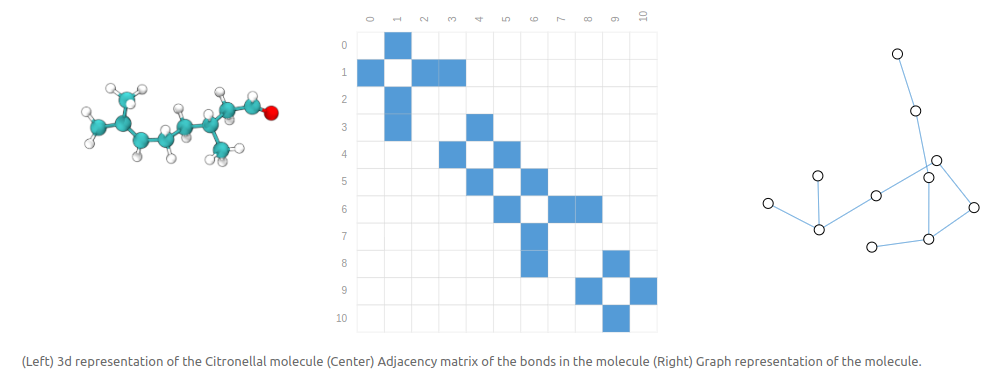


*Image source: [A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/)*

This example illustrates a powerful aspect of graphs, whereby the structure of the molecule is explicitly encoded into the graph representation itself. For example, which atoms are connected and how they are connected. Using this graph representation, we can accomplish a variety of different tasks. For example, in drug discovery we may be interested in testing whether different molecules bind together. 

There are several other applications of graphs that may surprise you, such as images! An image can be thought of as a graph with regular structure, whereby each pixel is a node with a 3-dimensional vector representing the RGB value of the pixel. Other examples include publication citation networks, whereby we can represent each paper as a node and each edge as a citation between papers.  

Having introduced graphs, lets go over some graph theory basics. 

## Section 1: Graphs, networkx

### Recap of graph fundamentals

A **graph** is a pair $\mathcal{G} = (\mathcal{V}, \mathcal{E})$, where $\mathcal{V}$ is the set of $N$ **vertices** (nodes), and $\mathcal{E}$ is the set of graph **edges** (links), i.e., pairs $(u,v)$ representing a connection between two vertices $u,v \in \mathcal{V}$. We will here consider **undirected** graphs, meaning that $(u,v) \in \mathcal{E} \implies (v,u) \in \mathcal{E}$.

There are several ways to represent $\mathcal{E}$:
1. As a **list of edges**: a list of pairs $(u,v)$, where $(u,v)$ means that there is an edge going from node $u$ to node $v$.
2. As an **adjacency matrix**: a binary square matrix $A$ of size $|\mathcal{V}| \times |\mathcal{V}|$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
3. As an **adjacency list**: An array of $|\mathcal{V}|$ unordered lists, where the $i$th list corresponds to the $i$th node, and contains all the nodes directly connected to node $i$.


Example: Below is a directed graph with four nodes and five edges.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/toy_graph.png" width="400px">

The arrows on the edges indicate the direction of each edge, e.g. there is an edge going from node 0 to node 1. Between node 0 and node 3, there are two edges: one going from node 0 to node 3 and one from node 3 to node 0.

Node 0 has out-degree of 2, since it has two outgoing edges, and an in-degree of 2, since it has two incoming edges.

The list of edges is:
$$[(0, 1), (0, 3), (1, 2), (2, 0), (3, 0)]$$

As adjacency matrix:

$$\begin{array}{l|llll}
 source \setminus dest    & n_0 & n_1 & n_2 & n_3 \\ \hline
n_0 & 0    & 1    & 0    & 1    \\
n_1 & 0    & 0    & 1    & 0    \\
n_2 & 1    & 0    & 0    & 0    \\
n_3 & 1    & 0    & 0    & 0
\end{array}$$

As adjacency list:

$$[\{1, 3\}, \{2\}, \{0\}, \{0\}]$$



### NetworkX





NetworkX is a Python library focused on graphs and networks, offering a large number of useful methods, including visualization which we will use several times in this colab.

Let's create and draw a simple graph:

Graph G with 5 nodes and 5 edges
Adjacency list: [(0, 2), (0, 4), (0, 5), (4, 5), (5, 6)]
Adjacency matrix (symmetric):
[[0 1 1 1 0]
 [1 0 0 0 0]
 [1 0 0 1 0]
 [1 0 1 0 1]
 [0 0 0 1 0]]
Degree of node 0: 3


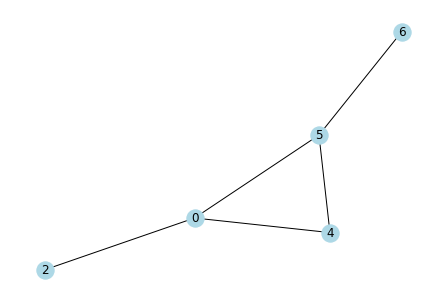

In [3]:
import networkx as nx 

# Create a simple graph
G = nx.Graph() # Use DiGraph for directed graphs

G.add_nodes_from([0, 2, 4, 5, 6]) # Fill in the list of node labels as integers
G.add_edges_from([(0, 2), (0, 4), (4, 5), (5, 6), (0, 5)]) # Fill in the list of node pairs [(node_a, node_b)]
# Note that for a NetworkX (undirected) Graph, you do not need to provide both (node_a, node_b) and (node_b, node_a)

# Print basic info
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
print(f'Graph G with {nb_nodes} nodes and {nb_edges} edges')
print(f'Adjacency list: {G.edges}')
print(f'Adjacency matrix (symmetric):')
A = nx.adjacency_matrix(G) # Returns a sparse matrix
print(A.todense())
print(f'Degree of node 0: {G.degree(0)}')

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue')

### ***Task 1: Graph definition***

The first task is to recreate the graph below using Networkx. Fill in your solution between `### BEGIN SOLUTION` and `### END SOLUTION`. Note that the position of the node in the graph you plot may differ from this image. What matters is that the same nodes are connected.

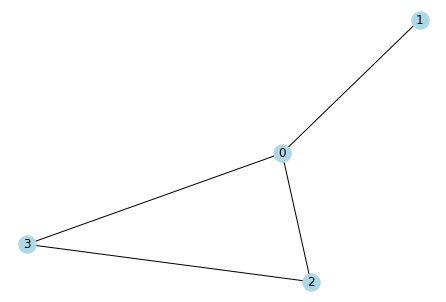

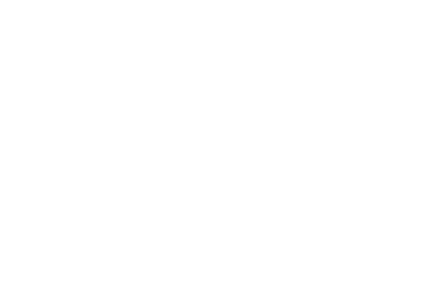

In [4]:
G = nx.Graph()
### BEGIN SOLUTION

### END SOLUTION
nx.draw(G, with_labels=True, node_color='lightblue')

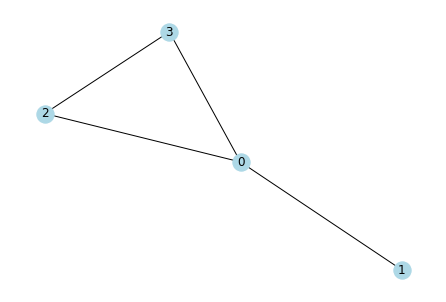

In [5]:
#@title ***Task 1: Solution*** { display-mode: "form" }
G = nx.Graph()
### BEGIN SOLUTION
G.add_nodes_from(range(4))
G.add_edges_from([(1, 0), (0, 2), (2, 3), (3, 0)])
## END SOLUTION
nx.draw(G, with_labels=True, node_color='lightblue')

## Section 2: Intro to the jraph Library

In the following sections, we will learn how to represent graphs and build GNNs in Python. We will use
[jraph](https://github.com/deepmind/jraph), a lightweight library for working with GNNs in [JAX](https://github.com/google/jax).

### Representing a graph in jraph

In jraph, a graph is represented with a `GraphsTuple` object. In addition to defining the graph structure of nodes and edges, you can also store node features, edge features and global graph features in a `GraphsTuple` (e.g. given a graph representing connections between cities, a node feature could be the number of people in that city).

In the `GraphsTuple`, edges are represented in two aligned arrays of node indices: senders (source nodes) and receivers (destinaton nodes).
Each index corresponds to one edge, e.g. edge `i` goes from `senders[i]` to `receivers[i]`.

You can even store multiple graphs in one `GraphsTuple` object, similar to how batching is done in standard machine learning.

We will start with creating a simple directed graph with 4 nodes and 5 edges. We will also add toy features to the nodes, using `2*node_index` as the feature.

We will later use this toy graph in the GCN demo.



In [6]:
def build_toy_graph() -> jraph.GraphsTuple:
  """Define a four node graph, each node has a scalar as its feature."""

  # Nodes are defined implicitly by their features.
  # We will add four nodes, each with a feature, e.g.
  # node 0 has feature [0.],
  # node 1 has featre [2.] etc.
  # len(node_features) is the number of nodes.
  node_features = jnp.array([[0.], [2.], [4.], [6.]])

  # We will now specify 5 directed edges connecting the nodes we defined above.
  # We define this with `senders` (source node indices) and `receivers`
  # (destination node indices).
  # For example, to add an edge from node 0 to node 1, we append 0 to senders,
  # and 1 to receivers.
  # We can do the same for all 5 edges:
  # 0 -> 1
  # 1 -> 2
  # 2 -> 0
  # 3 -> 0
  # 0 -> 3
  senders = jnp.array([0, 1, 2, 3, 0])
  receivers = jnp.array([1, 2, 0, 0, 3])

  # You can optionally add edge attributes to the 5 edges.
  edges = jnp.array([[5.], [6.], [7.], [8.], [8.]])

  # We then save the number of nodes and the number of edges.
  # This information is used to make running GNNs over multiple graphs
  # in a GraphsTuple possible.
  n_node = jnp.array([4])
  n_edge = jnp.array([5])

  # Optionally you can add `global` information, such as a graph label.
  global_context = jnp.array([[1]]) # Same feature dims as nodes and edges.

  # Now we create the graph.
  graph = jraph.GraphsTuple(
      nodes=node_features,
      edges=edges,
      senders=senders,
      receivers=receivers,
      n_node=n_node,
      n_edge=n_edge,
      globals=global_context
      )
  return graph

In [7]:
graph = build_toy_graph()

#### Inspecting the GraphsTuple


In [8]:
# Number of nodes
# Note that `n_node` returns an array. The length of `n_node` corresponds to
# the number of graphs stored in one `GraphsTuple`.
# In this case, we only have one graph, so n_node has length 1.
graph.n_node

DeviceArray([4], dtype=int32)

In [9]:
# Number of edges
graph.n_edge

DeviceArray([5], dtype=int32)

In [10]:
# Node features
graph.nodes

DeviceArray([[0.],
             [2.],
             [4.],
             [6.]], dtype=float32)

In [11]:
# Edge features
graph.edges

DeviceArray([[5.],
             [6.],
             [7.],
             [8.],
             [8.]], dtype=float32)

In [12]:
# Edges
graph.senders

DeviceArray([0, 1, 2, 3, 0], dtype=int32)

In [13]:
graph.receivers

DeviceArray([1, 2, 0, 0, 3], dtype=int32)

In [14]:
# Graph-level features
graph.globals

DeviceArray([[1]], dtype=int32)

#### Visualizing the Graph
To visualize the graph structure of the graph we created above, we will use the [`networkx`](networkx.org) library because it already has functions for drawing graphs.

We first convert the `jraph.GraphsTuple` to a `networkx.DiGraph`.

In [15]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

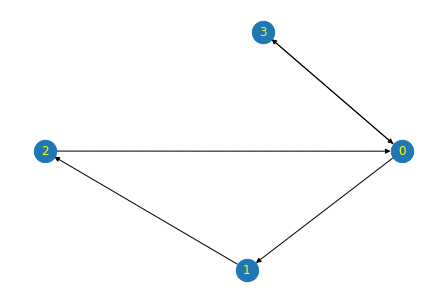

In [16]:
draw_jraph_graph_structure(graph)

### ***Task 2: GraphsTuple creation***

Create the same graph as before, but this time as a `jraph` GraphsTuple. Set the node attributes to be the numbers `[0, 1, 2, 3]` (corresponding to the node ID) and the edge attributes to be the sum of the adjacent node attributes.

Note that you will have to specify edges in both directions, since `jraph` uses directed graphs.

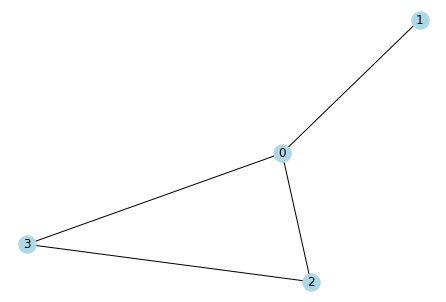

In [17]:
### BEGIN SOLUTION

### END SOLUTION

### UNCOMMENT THE FOLLOWING
# global_context = jnp.array([[1]])

# graph = jraph.GraphsTuple(
#     nodes=node_features,
#     edges=edges,
#     senders=senders,
#     receivers=receivers,
#     n_node=n_node,
#     n_edge=n_edge,
#     globals=global_context,
# )
# draw_jraph_graph_structure(graph)

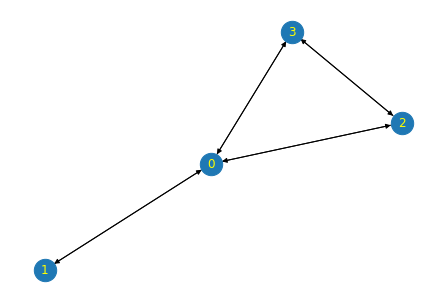

In [18]:
#@title ***Task 2: Solution*** { display-mode: "form" }
### BEGIN SOLUTION
node_features = jnp.array([[0.], [1.], [2.], [3.]])
sender_nodes = [1, 0, 2, 3]
receiver_nodes = [0, 2, 3, 0]
senders = jnp.array(sender_nodes + receiver_nodes)
receivers = jnp.array(receiver_nodes + sender_nodes)

edge_attributes = []
for i in range(4):
  edge_attributes.append([sender_nodes[i] + receiver_nodes[i]])
edges = jnp.array(edge_attributes + edge_attributes)

n_node = jnp.array([4])
n_edge = jnp.array([8])
### END SOLUTION

global_context = jnp.array([[1]])

graph = jraph.GraphsTuple(
    nodes=node_features,
    edges=edges,
    senders=senders,
    receivers=receivers,
    n_node=n_node,
    n_edge=n_edge,
    globals=global_context,
)
draw_jraph_graph_structure(graph)

## Section 3: Graph Neural Network Theory 

A GNN is a neural network designed to work on graph data. We start with an initial representation of our problem in the form of a graph. In the figure below, you can see an example of such a graph. The diagram illustrates new important aspects of graph neural networks: 
- Each node has an initial vector representation (grey box associated with each node) 
- Node are connected by different edge types (represented by different coloured arrows). 

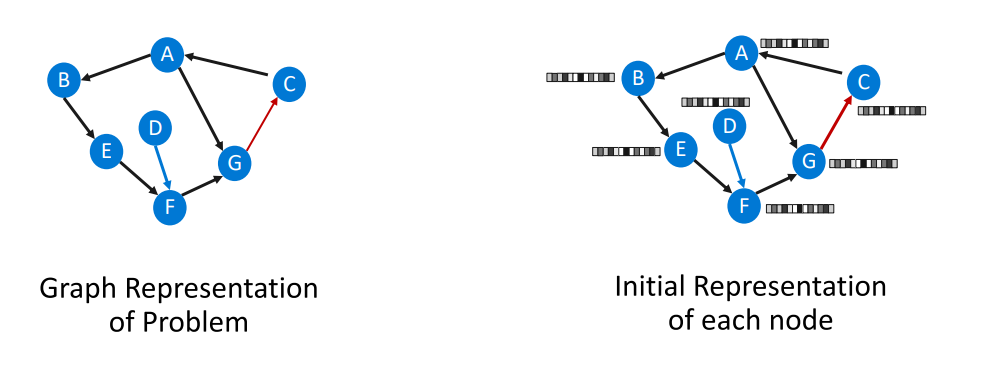

*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

The GNN updates these node representations during training, outputting task-specific output representations. An overview of this process is illustrated below: 

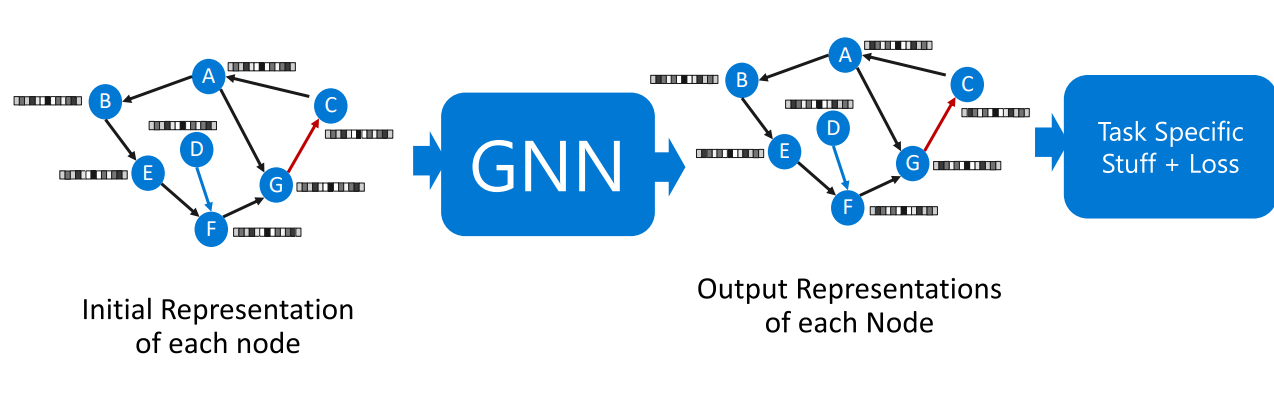


*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

Neural Message Passing is a popular framework to perform this update. In a nutshell, each node representation is updated by exchanging information with the neighbouring nodes. To examine the node update in detail, let's consider a smaller neighbourhood of the graph such as nodes D, E and F pictured below. 

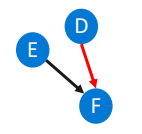

To update the vector representation of node F, we consider the following: 

- Current vector representation of node F 
- Vector representations of all nodes connected to F (e.g. E and D). 
- Edge types of connected nodes.  

For each neighbour node (e.g. E and F) we compute a 'message' using some function $f$, which takes in the adjacent node representation and edge type as input. The output of function $f$ is the message vector. There are a vareity of different functions we could use to prepare this message and we'll go into some concrete examples later in the tutorial.

The messages from all the adjacent nodes are then summarized and used to update the current node state. The diagram below illustrates this process, whereby the vector representation of node F at time $t$ is labelled as $h^{n}_{t-1}$. 

The notation is as follows: 
- $t$ = timestep 
- $h$ = node vector representation
- $k$ = edge type
- $f$ = function which prepares a message 
- $⋃$ = function which summarised the messages 
- $q$ = node update function 

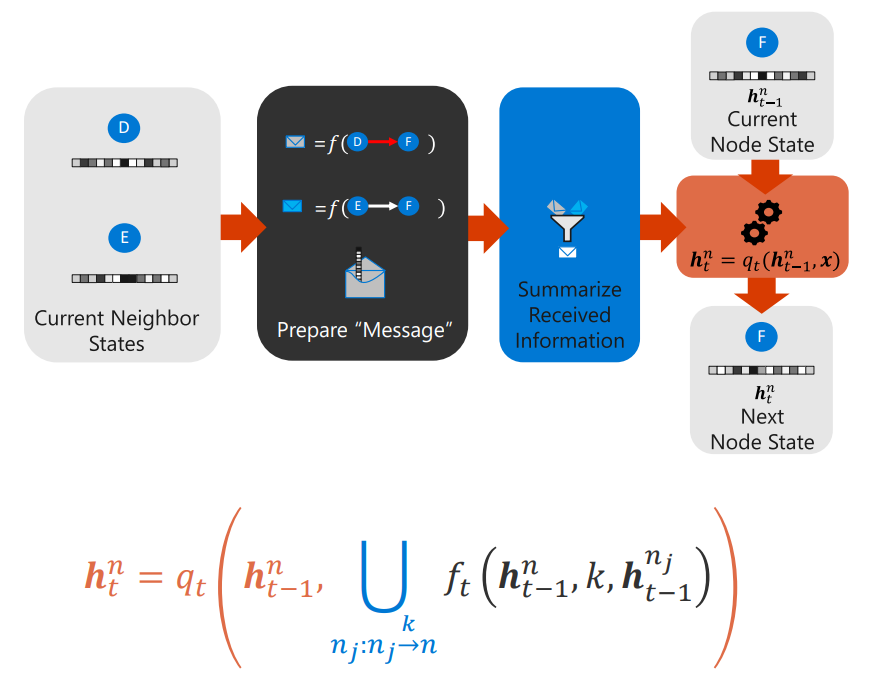

*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

The equation at the bottom of the image is coloured coded to match the step in the diagram. For example, black represents the function to prepare the message, blue the function to summarise these messages and orange to update the node step. 

Note that $⋃$ must be permutation invariant, as the messages are not ordered. 

### Graph Prediction Tasks
What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*The three main graph learning tasks. Image source: Petar Veličković.*

Which examples of graph prediction tasks come to your mind? Which task types do they correspond to?


## Section 4: Implementing GNN Models

The high-level perspective on the way GNNs are applied:



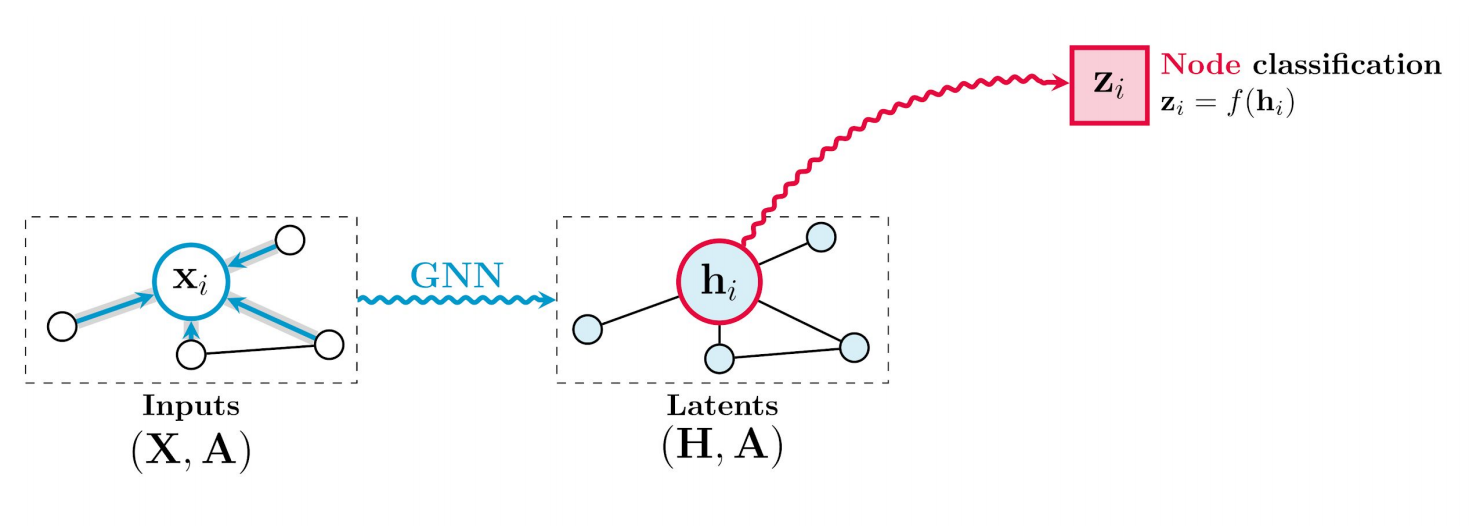

We start from a graph with adjacency matrix $A$ and node features $x_i$. Using a GNN, for each node we compute (based on its neighborhood) a latent feature vector $h_i$, by *aggregating* node features from adjacent nodes. With these latent vectors we can attempt to solve various tasks, where for now we focus on **node classification**.

In node classification, we are most often given a single graph, where only a portion of nodes is labeled. Using these nodes as a signal for training, our goal is to successfully classify the remaining nodes. To this end, we look at previously computed node latent vectors in isolation, and learn a classifier $z_i = f(h_i)$.




#### ***Implement MLP baseline***
First, let's define an MLP module which will be used to update the node features.

In [19]:
class MLP(hk.Module):
  def __init__(self, widening_factor:int, out_channels:int, number_classes: int = None):
    super().__init__()
    self.widening_factor = widening_factor
    self.out_channels = out_channels
    self.number_classes = number_classes

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:

    mlp = hk.Sequential([hk.Linear(self.out_channels),
                         jax.nn.relu,
                         hk.Linear(self.out_channels * self.widening_factor),
                         jax.nn.relu,
                         hk.Linear(self.out_channels if not self.number_classes else self.number_classes)])

    return mlp(x)

# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(widening_factor = 2, out_channels = 4)(x)

#### Check outputs of `update_node_fn` with MLP Block

In [20]:
graph = build_toy_graph()

In [21]:
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
out = update_node_module.apply(params, graph.nodes)

As output, we expect the updated node features. We should see one array of dim 4 for each of the 4 nodes, which is the result of applying a single MLP block to the features of each node individually.

In [22]:
out

DeviceArray([[ 0.        ,  0.        ,  0.        ,  0.        ],
             [-2.4262953 , -0.15340242,  2.5150187 , -1.2854769 ],
             [-4.8525906 , -0.30680484,  5.0300374 , -2.5709538 ],
             [-7.278886  , -0.4602071 ,  7.5450563 , -3.8564317 ]],            dtype=float32)

### ***Task 3: Custom update functions***

Node update functions do not even have to be neural networks. Using the code below as a framework, create a node update function `Add` which will add the given number to every node feature.

In [23]:
### BEGIN SOLUTION

### END SOLUTION

### UNCOMMENT THE FOLLOWING
# print("Before:\n", graph.nodes)
# update_node_fn = lambda x: Add(number_to_add=3)(x)
# update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
# params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
# out = update_node_module.apply(params, graph.nodes)
# print("After:\n", out)

In [24]:
#@title ***Task 3: Solution*** { display-mode: "form" }
### BEGIN SOLUTION
class Add(hk.Module):
  def __init__(self, number_to_add: int):
    super().__init__()
    self.number_to_add = number_to_add

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    return x + self.number_to_add
### END SOLUTION

print("Before:\n", graph.nodes)
update_node_fn = lambda x: Add(number_to_add=3)(x)
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
out = update_node_module.apply(params, graph.nodes)
print("After:\n", out)

Before:
 [[0.]
 [2.]
 [4.]
 [6.]]
After:
 [[3.]
 [5.]
 [7.]
 [9.]]


## Section 5: Graph Convoutional Network (GCN)

We can start working on our GCN (Graph Convolutional Network) model, which is a specific instance of GNNs.

Given as inputs $A$, the $N \times N$ adjacency matrix, and $H$, the $N \times F$ feature matrix, where each node has an $F$-dimensional feature vector, the propagation rule of mean-pool is as follows:
$$ H' = \sigma(D^{-1}AHW^T) $$
Here, $W$ is a learnable weight matrix of shape $F' \times F$, $D$ is the diagonal matrices containing the degree of the nodes, $\sigma(\cdot)$ is a non-linear activation function (e.g. ReLU), and H' holds the output node features ($N \times F'$).

Focusing on node $i$, we get the following equation for its features (where $\mathcal{N}(i)$ is the set of its neighbors):
$$ h'_i = \sigma \left( \frac{1}{\mathcal{N}(i)}\sum_{j \in \mathcal{N}(i)}  Wh_j \right) $$

In other words, we simply average the transformed features of all neighbors. 

#### Add Symmetric Normalization

Note that the nodes may have different numbers of neighbors / degrees.
This could lead to instabilities during neural network training, e.g. exploding or vanishing gradients. To address that, normalization is a commonly used method. In this case, we will normalize by node degrees.

As a first attempt, we could count the number of incoming edges (including self-edge) and divide by that value.

More formally, let $A$ be the adjacency matrix defining the edges of the graph.

Then we define the degree matrix $D$ as a diagonal matrix with $D_{ii} = \sum_jA_{ij}$ (the degree of node $i$)


Now we can normalize $AH$ by dividing it by the node degrees:
$${D}^{-1}AH$$

To take both the in and out degrees into account, we can use symmetric normalization, which is also what Kipf and Welling proposed in their [paper](https://arxiv.org/abs/1609.02907):
$$D^{-\frac{1}{2}}AD^{-\frac{1}{2}}H$$

our update function would then be:

$$ H' = \sigma(D^{-\frac{1}{2}}AD^{-\frac{1}{2}}HW^T) $$





#### Add Self-Edges to Graph (Edges connecting a node to itself)
For each node, add an edge of the node onto itself. This way, nodes will include themselves in the aggregation step.

*Note*: if we don't add self-edges, a node would not depend on its own features which is often undesirable.

In [25]:
def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

### GCN Layer implementation
Now we can write a more general and configurable version of the Graph Convolution layer, allowing the caller to specify:

*   **`update_node_fn`**: Function to use to update node features (e.g. the MLP block version we just implemented)
*   **`aggregate_nodes_fn`**: Aggregation function to use to aggregate messages from neighbourhood.
*  **`add_self_edges`**: Whether to add self edges for aggregation step.
* **`symmetric_normalization`**: Whether to add symmetric normalization.



In [26]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(update_node_fn: Callable,
                    aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                    add_self_edges: bool = False,
                    symmetric_normalization: bool = True) -> Callable:
    """Returns a method that applies a Graph Convolution layer.

    Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
    NOTE: This implementation does not add an activation after aggregation.
    If you are stacking layers, you may want to add an activation between
    each layer.
    
    Args:
        update_node_fn: function used to update the nodes. In the paper a single
        layer MLP is used.
        aggregate_nodes_fn: function used to aggregates the sender nodes.
        add_self_edges: whether to add self edges to nodes in the graph as in the
        paper definition of GCN. Defaults to False.
        symmetric_normalization: whether to use symmetric normalization. Defaults to
        True.

    Returns:
        A method that applies a Graph Convolution layer.
    """
    
    def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        """Applies a Graph Convolution layer."""
        nodes, _, receivers, senders, _, _, _ = graph

        # First pass nodes through the node updater.
        nodes = update_node_fn(nodes)
        # Equivalent to jnp.sum(n_node), but jittable
        total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
        if add_self_edges:
            # We add self edges to the senders and receivers so that each node
            # includes itself in aggregation.
            # In principle, a `GraphsTuple` should partition by n_edge, but in
            # this case it is not required since a GCN is agnostic to whether
            # the `GraphsTuple` is a batch of graphs or a single large graph.
            conv_receivers, conv_senders = add_self_edges_fn(receivers, senders,
                                                        total_num_nodes)
        else:
            conv_senders = senders
            conv_receivers = receivers

        # pylint: disable=g-long-lambda
        if symmetric_normalization:
            # Calculate the normalization values.
            count_edges = lambda x: jax.ops.segment_sum(
                jnp.ones_like(conv_senders), x, total_num_nodes)
            sender_degree = count_edges(conv_senders)
            receiver_degree = count_edges(conv_receivers)

            # Pre normalize by sqrt sender degree.
            # Avoid dividing by 0 by taking maximum of (degree, 1).
            nodes = tree.tree_map(
                lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
                nodes,
            )
            # Aggregate the pre-normalized nodes.
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
            # Post normalize by sqrt receiver degree.
            # Avoid dividing by 0 by taking maximum of (degree, 1).
            nodes = tree.tree_map(
                lambda x:
                (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
                nodes,
            )
        else:
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
        # pylint: enable=g-long-lambda
        return graph._replace(nodes=nodes)

    return _ApplyGCN

#### Test General GCN Layer

In [27]:
gcn_layer = GraphConvolution(
    update_node_fn = lambda n: MLP(widening_factor = 2, out_channels = 4)(n),
    aggregate_nodes_fn = jax.ops.segment_sum,
    add_self_edges = True,
    symmetric_normalization = True
)

In [28]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-4.9526544 , -0.3131313 ,  5.13376   , -2.623969  ],
             [-1.2131476 , -0.0767012 ,  1.2575092 , -0.64273846],
             [-3.639443  , -0.23010363,  3.772528  , -1.9282154 ],
             [-3.6394427 , -0.23010354,  3.772528  , -1.9282157 ]],            dtype=float32)

### ***Task 4: Asymmetric normalization***

By adapting the above `GraphConvolution` function, write a function `GraphConvolutionNormalize` which has an option for `normalization` instead of `symmetric_normalization`. The definition of this GCN layer should correspond to normalization which only considers the incoming edges
$${D}^{-1}AH$$
instead of symmetric normalization
$$D^{-\frac{1}{2}}AD^{-\frac{1}{2}}H$$

In [29]:
def GraphConvolutionNormalize(update_node_fn: Callable,
                              aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                              add_self_edges: bool = False,
                              normalization: bool = True) -> Callable:    
    def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        nodes, _, receivers, senders, _, _, _ = graph

        nodes = update_node_fn(nodes)
        total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
        if add_self_edges:
            conv_receivers, conv_senders = add_self_edges_fn(receivers, senders, total_num_nodes)
        else:
            conv_senders = senders
            conv_receivers = receivers

        # pylint: disable=g-long-lambda
        if normalization:
            ### BEGIN SOLUTION
            nodes = nodes # REMOVE THIS LINE
            ### END SOLUTION
        else:
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
        # pylint: enable=g-long-lambda
        return graph._replace(nodes=nodes)

    return _ApplyGCN

gcn_layer = GraphConvolutionNormalize(
    update_node_fn = lambda n: MLP(widening_factor = 2, out_channels = 4)(n),
    aggregate_nodes_fn = jax.ops.segment_sum,
    add_self_edges = True,
    normalization = True
)

graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[ 0.        ,  0.        ,  0.        ,  0.        ],
             [-2.4262953 , -0.15340242,  2.5150187 , -1.2854769 ],
             [-4.8525906 , -0.30680484,  5.0300374 , -2.5709538 ],
             [-7.278886  , -0.4602071 ,  7.5450563 , -3.8564317 ]],            dtype=float32)

In [30]:
#@title ***Task 4: Solution*** { display-mode: "form" }
def GraphConvolutionNormalize(update_node_fn: Callable,
                              aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                              add_self_edges: bool = False,
                              normalization: bool = True) -> Callable:    
    def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        nodes, _, receivers, senders, _, _, _ = graph

        nodes = update_node_fn(nodes)
        total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
        if add_self_edges:
            conv_receivers, conv_senders = add_self_edges_fn(receivers, senders, total_num_nodes)
        else:
            conv_senders = senders
            conv_receivers = receivers

        # pylint: disable=g-long-lambda
        if normalization:
            ### BEGIN SOLUTION
            # Calculate the node degrees
            count_edges = lambda x: jax.ops.segment_sum(
                jnp.ones_like(conv_senders), x, total_num_nodes)
            receiver_degree = count_edges(conv_receivers)

            # Aggregate the nodes.
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
            # Normalize by receiver degree.
            # Avoid dividing by 0 by taking maximum of (degree, 1).
            nodes = tree.tree_map(
                lambda x:
                (x * jnp.maximum(receiver_degree, 1.0)[:, None]),
                nodes,
            )
            # END SOLUTION
        else:
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
        # pylint: enable=g-long-lambda
        return graph._replace(nodes=nodes)

    return _ApplyGCN

gcn_layer = GraphConvolutionNormalize(
    update_node_fn = lambda n: MLP(widening_factor = 2, out_channels = 4)(n),
    aggregate_nodes_fn = jax.ops.segment_sum,
    add_self_edges = True,
    normalization = True
)

graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-36.39443   ,  -2.301036  ,  37.72528   , -19.282156  ],
             [ -4.8525906 ,  -0.30680484,   5.0300374 ,  -2.5709538 ],
             [-14.557772  ,  -0.9204145 ,  15.090113  ,  -7.7128615 ],
             [-14.557772  ,  -0.9204142 ,  15.090113  ,  -7.7128634 ]],            dtype=float32)

### Build GCN Model with Multiple Layers
With a single GCN layer, a node's representation after the GCN layer is only
influenced by its direct neighbourhood. However, we may want to consider larger neighbourhoods, i.e. more than just 1 hop away. To achieve that, we can stack
multiple GCN layers, similar to how stacking CNN layers expands the input region.

We will define a network with three GCN layers:

In [31]:
def gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with 3 GCN layers.
    
    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)
    
    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
        add_self_edges=True)
    
    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2))
    
    graph = gn(graph)
    
    return graph

In [32]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-0.32386127,  0.10707338],
             [-0.23884146,  0.07896456],
             [-0.19206828,  0.06350064],
             [-0.23884146,  0.07896456]], dtype=float32)

### Node Classification with GCN on Karate Club Dataset

Time to try out our GCN on our first graph prediction task!


#### Zachary's Karate Club Dataset

[Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a small dataset commonly used as an example for a social graph. It's great for demo purposes, as it's easy to visualize and quick to train a model on it.

A node represents a student or instructor in the club. An edge means that those two people have interacted outside of the class. There are two instructors in the club.

Each student is assigned to one of two instructors.

#### Optimizing the GCN on the Karate Club Node Classification Task

The task is to predict the assignment of students to instructors, given the social graph and only knowing the assignment of two nodes (the two instructors) a priori.

In other words, out of the 34 nodes, only two nodes are labeled, and we are trying to optimize the assignment of the other 32 nodes, by **maximizing the log-likelihood of the two known node assignments**.

We will compute the accuracy of our node assignments by comparing to the ground-truth assignments. **Note that the ground-truth for the 32 student nodes is not used in the loss function itself.**

Let's load the dataset:

In [33]:
"""Zachary's karate club example.
From https://github.com/deepmind/jraph/blob/master/jraph/examples/zacharys_karate_club.py.
Here we train a graph neural network to process Zachary's karate club.
https://en.wikipedia.org/wiki/Zachary%27s_karate_club
Zachary's karate club is used in the literature as an example of a social graph.
Here we use a graphnet to optimize the assignments of the students in the
karate club to two distinct karate instructors (Mr. Hi and John A).
"""

def get_zacharys_karate_club() -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""
  social_graph = [
      (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
      (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
      (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
      (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
      (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)]
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  n_club_members = 34

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  return jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                    0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [34]:
graph = get_zacharys_karate_club()

In [35]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')

Number of nodes: 34
Number of edges: 156


Visualize the karate club graph with circular node layout:

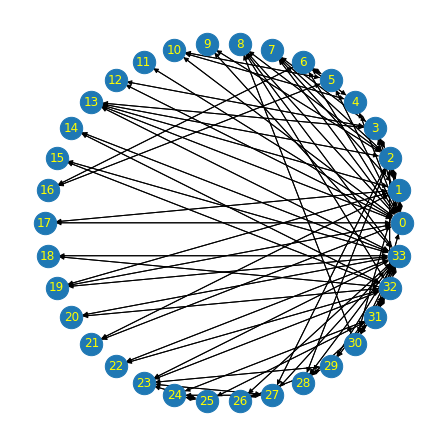

In [36]:
nx_graph = convert_jraph_to_networkx_graph(graph)
pos = nx.circular_layout(nx_graph)
plt.figure(figsize=(6, 6))
nx.draw(nx_graph, pos=pos, with_labels = True, node_size=500, font_color='yellow')

Define the GCN with the `GraphConvolution` layers we implemented:

In [37]:
def gcn_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a GCN for the karate club task.
    
    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)
    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2)) # output dim is 2 because we have 2 output classes.
    graph = gn(graph)
    return graph

Training and evaluation code:

In [38]:
def optimize_club(network: hk.Transformed, params: hk.Params, \
                  graph_karate_club: jraph.GraphsTuple, labels: jnp.ndarray, \
                  num_steps: int) -> jnp.ndarray:
    """Solves the karate club problem by optimizing the assignments of students."""

    @jax.jit
    def predict(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, graph_karate_club)
        return jnp.argmax(decoded_graph.nodes, axis=1)

    @jax.jit
    def prediction_loss(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, graph_karate_club)
        # We interpret the decoded nodes as a pair of logits for each node.
        log_prob = jax.nn.log_softmax(decoded_graph.nodes)
        # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
        # and John A (Node 33).
        return -(log_prob[0, 0] + log_prob[33, 1])

    opt_init, opt_update = optax.adam(1e-2)
    opt_state = opt_init(params)

    @jax.jit
    def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
        """Returns updated params and state."""
        g = jax.grad(prediction_loss)(params)
        updates, opt_state = opt_update(g, opt_state)
        return optax.apply_updates(params, updates), opt_state

    @jax.jit
    def accuracy(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, graph_karate_club)
        return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

    for step in range(num_steps):
        print(f"step {step} accuracy {accuracy(params).item():.2f}")
        params, opt_state = update(params, opt_state)

    return predict(params)

Let's train the GCN! We expect this model reach an accuracy of about 0.91.

In [39]:
network = hk.without_apply_rng(hk.transform(gcn_definition))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

step 0 accuracy 0.06
step 1 accuracy 0.15
step 2 accuracy 0.35
step 3 accuracy 0.50
step 4 accuracy 0.59
step 5 accuracy 0.68
step 6 accuracy 0.71
step 7 accuracy 0.74
step 8 accuracy 0.74
step 9 accuracy 0.76
step 10 accuracy 0.76
step 11 accuracy 0.91
step 12 accuracy 0.91
step 13 accuracy 0.91
step 14 accuracy 0.91


Node assignments predicted by the model at the end of training:

In [40]:
result

DeviceArray([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

Visualize ground truth and predicted node assignments:

What do you think of the results?

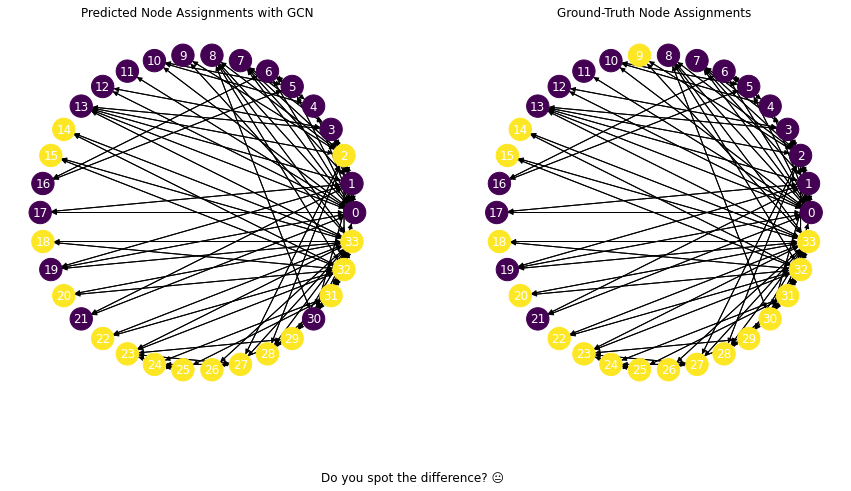

In [41]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GCN')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)

plt.show()

### ***Task 5: Training a Deeper GCN***

Lets try train a deeper GCN! Lets start off with 3 layers and see if that improves performance. Then try 5! 

#### 5a) 3-Layer GCN 

In [42]:
def gcn_3_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with more GCN layers.
    
    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """    
    ### BEGIN SOLUTION

    ### END SOLUTION

    return graph 

network = hk.without_apply_rng(hk.transform(gcn_3_layer))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

step 0 accuracy 0.03
step 1 accuracy 0.03
step 2 accuracy 0.03
step 3 accuracy 0.03
step 4 accuracy 0.03
step 5 accuracy 0.03
step 6 accuracy 0.03
step 7 accuracy 0.03
step 8 accuracy 0.03
step 9 accuracy 0.03
step 10 accuracy 0.03
step 11 accuracy 0.03
step 12 accuracy 0.03
step 13 accuracy 0.03
step 14 accuracy 0.03


#### 5b) 5-Layer GCN 

In [43]:
def gcn_5_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with more GCN layers.
    
    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """    
    ### BEGIN SOLUTION

    ### END SOLUTION

    return graph 

network = hk.without_apply_rng(hk.transform(gcn_5_layer))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

step 0 accuracy 0.03
step 1 accuracy 0.03
step 2 accuracy 0.03
step 3 accuracy 0.03
step 4 accuracy 0.03
step 5 accuracy 0.03
step 6 accuracy 0.03
step 7 accuracy 0.03
step 8 accuracy 0.03
step 9 accuracy 0.03
step 10 accuracy 0.03
step 11 accuracy 0.03
step 12 accuracy 0.03
step 13 accuracy 0.03
step 14 accuracy 0.03


In [44]:
#@title ***Task 5: Solution*** { display-mode: "form" }
def gcn_3_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with 3 GCN layers.
    
    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)
    
    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
        add_self_edges=True)
    
    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2))
    
    graph = gn(graph)
    
    return graph


def gcn_5_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with more GCN layers.
    
    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """    
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)
    

    for _ in range(3): 
      gn = GraphConvolution(
          update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)), 
          add_self_edges=True
        )

      graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2))
    
    graph = gn(graph)

    return graph 


graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()

print("----- 3-LAYER GCN -----")
network_3_layer = hk.without_apply_rng(hk.transform(gcn_3_layer))
params = network_3_layer.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network_3_layer, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

print("----- 5-LAYER GCN -----")
network_5_layer = hk.without_apply_rng(hk.transform(gcn_5_layer))
params = network_5_layer.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network_5_layer, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)


----- 3-LAYER GCN -----
step 0 accuracy 0.50
step 1 accuracy 0.65
step 2 accuracy 0.97
step 3 accuracy 0.94
step 4 accuracy 0.94
step 5 accuracy 0.94
step 6 accuracy 0.94
step 7 accuracy 0.94
step 8 accuracy 0.97
step 9 accuracy 0.94
step 10 accuracy 0.94
step 11 accuracy 0.94
step 12 accuracy 0.94
step 13 accuracy 0.97
step 14 accuracy 0.97
----- 5-LAYER GCN -----
step 0 accuracy 0.50
step 1 accuracy 0.50
step 2 accuracy 0.50
step 3 accuracy 0.50
step 4 accuracy 0.50
step 5 accuracy 0.50
step 6 accuracy 0.50
step 7 accuracy 0.50
step 8 accuracy 0.50
step 9 accuracy 0.50
step 10 accuracy 0.50
step 11 accuracy 0.65
step 12 accuracy 0.68
step 13 accuracy 0.68
step 14 accuracy 0.68


## Section 6: Graph Attention Network (GAT)

While the coefficents in GCN were dependent on both nodes, they were still constant. If we relax this to make them dependent on the current input, we get **attention**. Namely, our update rule for one node will now be:
$$ h'_i = \sigma \left( \sum_{j \in \mathcal{N}(i)} \alpha_{ij} W h_j \right) $$
where $\alpha_{ij}$ are the **attention coefficients**, determining how much of the incoming "message" from node $j$ should node $i$ take in and $\sigma$ is the ELU. 

To compute $\alpha_{ij}$ we apply a one-layer MLP $a$ on concatenated "messages" $Wh_i$ and $Wh_j$ with LeakyReLU activation:

$$\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[W h_i||W h_j\right]\right)\right)}{\sum_{k\in\mathcal{N}(i)} \exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[W h_i||W h_k\right]\right)\right)}$$

Softmax is applied as normalization, s.t. the sum of coefficients each node uses to receive messages is the same irrespective of the size of the neighborhood.


To stabilize learning, similar to the original Transformer paper, GAT employs **multi-head attention**: each GAT layer has $K$ independent replicas, whose results are simply concatenated to obtain final feature vectors, or averaged if we are at the output layer. Here is a visualization:

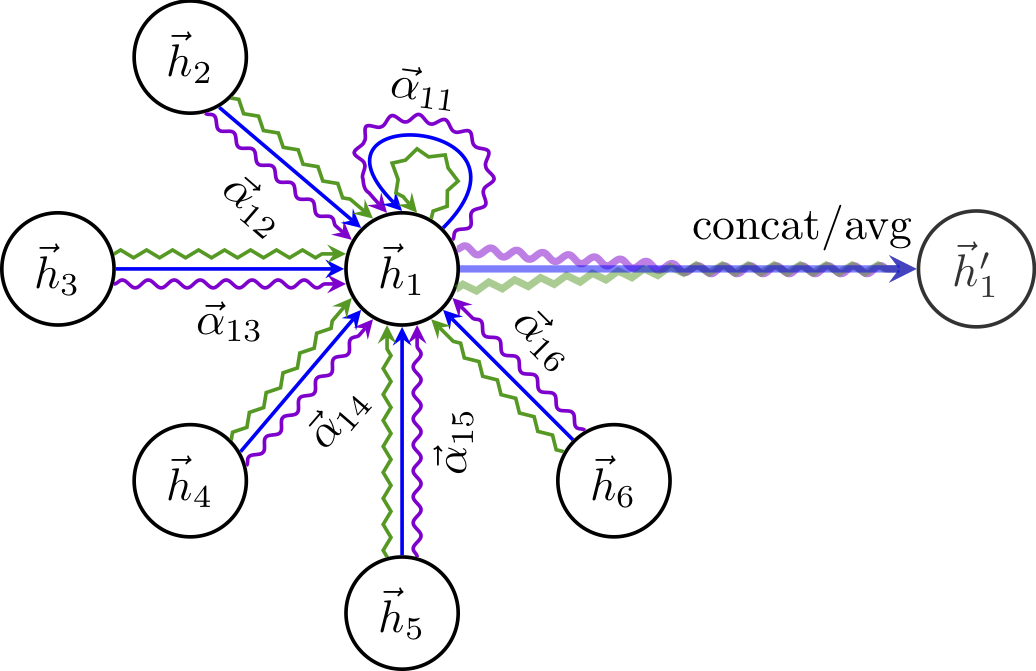

In [45]:
# GAT implementation adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L442.
def GAT(attention_query_fn: Callable,
        attention_logit_fn: Callable,
        node_update_fn: Optional[Callable] = None,
        add_self_edges: bool = True) -> Callable:
  """Returns a method that applies a Graph Attention Network layer.

  Graph Attention message passing as described in
  https://arxiv.org/pdf/1710.10903.pdf. This model expects node features as a
  jnp.array, may use edge features for computing attention weights, and
  ignore global features. It does not support nests.
  Args:
    attention_query_fn: function that generates attention queries from sender
      node features.
    attention_logit_fn: function that converts attention queries into logits for
      softmax attention.
    node_update_fn: function that updates the aggregated messages. If None, will
      apply leaky relu and concatenate (if using multi-head attention).

  Returns:
    A function that applies a Graph Attention layer.
  """
  # pylint: disable=g-long-lambda
  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Attention layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders,
                                             total_num_nodes)

    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(sent_attributes,
                                            received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(
        att_softmax_logits, segment_ids=receivers, num_segments=sum_n_node)

    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGAT

#### Test GAT Layer

In [46]:
def attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                       edges: jnp.ndarray) -> jnp.ndarray:
  del edges
  x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
  return hk.Linear(1)(x)


gat_layer = GAT(
    attention_query_fn=lambda n: hk.Linear(8)
    (n),  # Applies W to the node features
    attention_logit_fn=attention_logit_fn,
    node_update_fn=None,
    add_self_edges=True,
)

In [47]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gat_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-2.1254564e-02,  2.4042883e+00, -4.0143323e-03,
              -2.0577878e-02,  1.8933861e+00,  1.1548430e+00,
              -5.3817675e-02, -1.0350263e-02],
             [-6.7768167e-03,  7.6658463e-01, -1.2799320e-03,
              -6.5610623e-03,  6.0368830e-01,  3.6821079e-01,
              -1.7159257e-02, -3.3000836e-03],
             [-2.1208903e-02,  2.3991234e+00, -4.0057087e-03,
              -2.0533672e-02,  1.8893188e+00,  1.1523622e+00,
              -5.3702068e-02, -1.0328028e-02],
             [-1.7733721e-02,  2.0060153e+00, -3.3493536e-03,
              -1.7169129e-02,  1.5797446e+00,  9.6354198e-01,
              -4.4902720e-02, -8.6357296e-03]], dtype=float32)

### Train GAT Model on Karate Club Dataset
We will now repeat the karate club experiment with a GAT network.

In [48]:
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """

  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
    return hk.Linear(1)(x)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(2),
      add_self_edges=True)
  graph = gn(graph)
  return graph

Let's train the model!

We expect the model to reach an accuracy of about 0.97.

In [49]:
network = hk.without_apply_rng(hk.transform(gat_definition))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

step 0 accuracy 0.50
step 1 accuracy 0.94
step 2 accuracy 0.94
step 3 accuracy 0.94
step 4 accuracy 0.97
step 5 accuracy 0.97
step 6 accuracy 0.97
step 7 accuracy 0.97
step 8 accuracy 0.97
step 9 accuracy 0.97
step 10 accuracy 1.00
step 11 accuracy 1.00
step 12 accuracy 1.00
step 13 accuracy 0.97
step 14 accuracy 0.97


The final node assignment predicted by the trained model:

In [50]:
result

DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

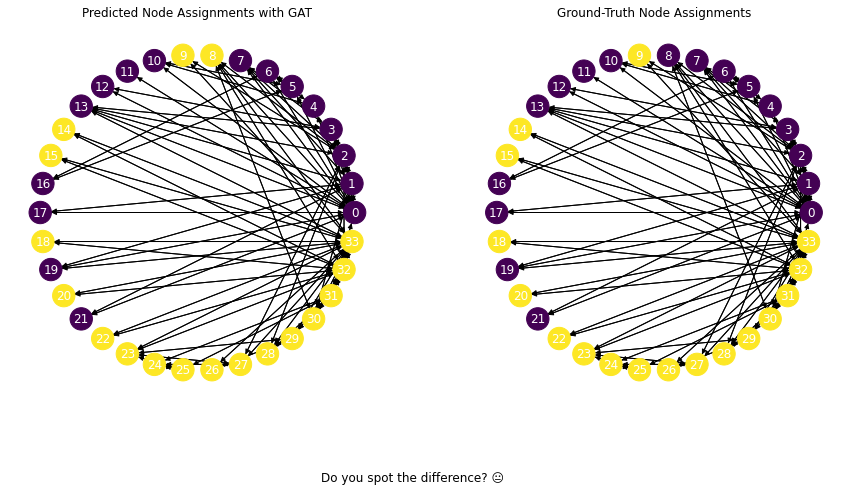

In [51]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GAT')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)
plt.show()

### ***Task 6: Conditioning Attention Coefficients on only the Senders***
In GATs, each attention coefficient $\alpha_{ij}$ is computed by applying a one-layer MLP $a$ on concatenated "messages" $Wh_i$ and $Wh_j$. Thus, it is dependent on both the sender and receiver.

For this task, by modifying the code below, create a GAT which computes attention coefficients by conditioning on only the senders.

In [66]:
### BEGIN SOLUTION
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """

  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
    return hk.Linear(1)(x)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(2),
      add_self_edges=True)
  graph = gn(graph)
  return graph

network = hk.without_apply_rng(hk.transform(gat_definition))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)
### END SOLUTION

step 0 accuracy 0.50
step 1 accuracy 0.94
step 2 accuracy 0.94
step 3 accuracy 0.94
step 4 accuracy 0.97
step 5 accuracy 0.97
step 6 accuracy 0.97
step 7 accuracy 0.97
step 8 accuracy 0.97
step 9 accuracy 0.97
step 10 accuracy 1.00
step 11 accuracy 1.00
step 12 accuracy 1.00
step 13 accuracy 0.97
step 14 accuracy 0.97


In [67]:
#@title ***Task 6: Solution*** { display-mode: "form" }

### BEGIN SOLUTION
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """

  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    return hk.Linear(1)(sender_attr)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(2),
      add_self_edges=True)
  graph = gn(graph)
  return graph

network = hk.without_apply_rng(hk.transform(gat_definition))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)
### END SOLUTION

step 0 accuracy 0.50
step 1 accuracy 0.97
step 2 accuracy 0.94
step 3 accuracy 0.94
step 4 accuracy 0.97
step 5 accuracy 0.97
step 6 accuracy 0.97
step 7 accuracy 0.97
step 8 accuracy 0.97
step 9 accuracy 1.00
step 10 accuracy 1.00
step 11 accuracy 1.00
step 12 accuracy 1.00
step 13 accuracy 1.00
step 14 accuracy 1.00


## **Extension 1:** Graph Classification on MUTAG (Molecules)
Up until this point, we have only used our GCN and GAT networks on node classification problems. Now, let's use the same model architectures on a **graph classification** task.

The main difference from our previous setup is that instead of observing individual node latents, we are now attempting to summarize them into one embedding vector, representative of the entire graph, which we then use to predict the class of this graph.

We will do this on one of the most common tasks of this type -- **molecular property prediction**, where molecules are represented as graphs. Nodes correspond to atoms, and edges represent the bonds between them.

### Setting up the dataset
We will use the **MUTAG** dataset for this example, a common dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) collection.

We have converted this dataset to be compatible with jraph and will download it in the cell below.

Citation for TUDatasets: [Morris, Christopher, et al. Tudataset: A collection of benchmark datasets for learning with graphs. arXiv preprint arXiv:2007.08663. 2020.](https://chrsmrrs.github.io/datasets/)

In [52]:
# Download jraph version of MUTAG.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
with open('/tmp/mutag.pickle', 'rb') as f:
  mutag_ds = pickle.load(f)

--2022-07-18 13:32:53--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.164.176, 172.217.0.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352981 (345K) [application/octet-stream]
Saving to: ‘/tmp/mutag.pickle’

mutag.pickle        100%[===================>] 344.71K  --.-KB/s    in 0.003s  

2022-07-18 13:32:53 (132 MB/s) - ‘/tmp/mutag.pickle’ saved [352981/352981]



The dataset is saved as a list of examples, each example is a dictionary containing an `input_graph` and its corresponding target.

In [53]:
len(mutag_ds)

188

In [54]:
# Inspect the first graph
g = mutag_ds[0]['input_graph']
print(f'Number of nodes: {g.n_node[0]}')
print(f'Number of edges: {g.n_edge[0]}')
print(f'Node features shape: {g.nodes.shape}')
print(f'Edge features shape: {g.edges.shape}')

Number of nodes: 17
Number of edges: 38
Node features shape: (17, 7)
Edge features shape: (38, 4)


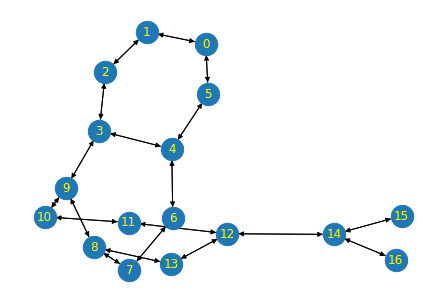

In [55]:
draw_jraph_graph_structure(g)

In [68]:
# Target for first graph
print(f"Target: {mutag_ds[0]['target']}")

Target: [1]


We see that there are 188 graphs, to be classified in one of 2 classes, representing "their mutagenic effect on a specific gram negative bacterium". Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br). Edge features (`edge_attr`) represent the bond type, which we will here ignore.

Let's split the dataset to use the first 150 graphs as the training set (and the rest as the test set).

In [69]:
train_mutag_ds = mutag_ds[:150]
test_mutag_ds = mutag_ds[150:]

### Padding Graphs to Speed Up Training
Since jax recompiles the program for each graph size, training would take a long time due to recompilation for different graph sizes. To address that, we pad the number of nodes and edges in the graphs to nearest power of two. Since jax maintains a cache of compiled programs, the compilation cost is amortized.

In [70]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def _nearest_bigger_power_of_two(x: int) -> int:
  """Computes the nearest power of two greater than x for padding."""
  y = 2
  while y < x:
    y *= 2
  return y

def pad_graph_to_nearest_power_of_two(
    graphs_tuple: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Pads a batched `GraphsTuple` to the nearest power of two.
  For example, if a `GraphsTuple` has 7 nodes, 5 edges and 3 graphs, this method
  would pad the `GraphsTuple` nodes and edges:
    7 nodes --> 8 nodes (2^3)
    5 edges --> 8 edges (2^3)
  And since padding is accomplished using `jraph.pad_with_graphs`, an extra
  graph and node is added:
    8 nodes --> 9 nodes
    3 graphs --> 4 graphs
  Args:
    graphs_tuple: a batched `GraphsTuple` (can be batch size 1).
  Returns:
    A graphs_tuple batched to the nearest power of two.
  """
  # Add 1 since we need at least one padding node for pad_with_graphs.
  pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_node)) + 1
  pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_edge))
  # Add 1 since we need at least one padding graph for pad_with_graphs.
  # We do not pad to nearest power of two because the batch size is fixed.
  pad_graphs_to = graphs_tuple.n_node.shape[0] + 1
  return jraph.pad_with_graphs(graphs_tuple, pad_nodes_to, pad_edges_to,
                               pad_graphs_to)

### Graph Network Model Definition
We will use jraph.GraphNetwork() to build our graph model. The GraphNetwork architecture is defined in [Battaglia et al. (2018)](https://arxiv.org/pdf/1806.01261.pdf). It is a simple extension of what we have been working with so far and a commonly used framework for expressing GNNs.

When aggregating features from neighbours, edge features are first updated using `edge_update_fn` based on features from the *two adjacent nodes*, then node features are updated using `node_update_fn` based on features from *all adjacent edges*. Finally, the global feature is updated using `update_global_fn` based on all node and edge features.

A representation of this is shown below, where $\theta$ represents update functions, $\rho$ represents aggregation, $u$ is the global feature, $V$ is the node features, and $E$ is the edge features.

<img src="https://www.mdpi.com/applsci/applsci-12-03881/article_deploy/html/images/applsci-12-03881-g003.png" width="60%" />

We first define update functions for nodes, edges, and the full graph (global). We will use MLP blocks for all three.

In [71]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
@jraph.concatenated_args
def edge_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Edge update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)

@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Global update function for graph net."""
  # MUTAG is a binary classification task, so output pos neg logits.
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(2)])
  return net(feats)

def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Add a global paramater for graph classification.
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  embedder = jraph.GraphMapFeatures(
      hk.Linear(128), hk.Linear(128), hk.Linear(128))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn,
      update_edge_fn=edge_update_fn,
      update_global_fn=update_global_fn)
  return net(embedder(graph))

### Loss and Accuracy Function
Define the classification cross-entropy loss and accuracy function.

In [72]:
def compute_loss(params: hk.Params, graph: jraph.GraphsTuple, label: jnp.ndarray,
                 net: jraph.GraphsTuple) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss and accuracy."""
  pred_graph = net.apply(params, graph)
  preds = jax.nn.log_softmax(pred_graph.globals)
  targets = jax.nn.one_hot(label, 2)

  # Since we have an extra 'dummy' graph in our batch due to padding, we want
  # to mask out any loss associated with the dummy graph.
  # Since we padded with `pad_with_graphs` we can recover the mask by using
  # get_graph_padding_mask.
  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  loss = -jnp.mean(preds * targets * mask[:, None])

  # Accuracy taking into account the mask.
  accuracy = jnp.sum(
      (jnp.argmax(pred_graph.globals, axis=1) == label) * mask) / jnp.sum(mask)
  return loss, accuracy

### Training and Evaluation Functions

In [73]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def train(dataset: List[Dict[str, Any]], num_train_steps: int, graph_net=net_fn) -> hk.Params:
  """Training loop."""

  # Transform impure `graph_net` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(graph_net))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  # Initialize the network.
  params = net.init(jax.random.PRNGKey(42), graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(
      compute_loss_fn, has_aux=True))

  for idx in range(num_train_steps):
    graph = dataset[idx % len(dataset)]['input_graph']
    label = dataset[idx % len(dataset)]['target']
    # Jax will re-jit your graphnet every time a new graph shape is encountered.
    # In the limit, this means a new compilation every training step, which
    # will result in *extremely* slow training. To prevent this, pad each
    # batch of graphs to the nearest power of two. Since jax maintains a cache
    # of compiled programs, the compilation cost is amortized.
    graph = pad_graph_to_nearest_power_of_two(graph)

    # Since padding is implemented with pad_with_graphs, an extra graph has
    # been added to the batch, which means there should be an extra label.
    label = jnp.concatenate([label, jnp.array([0])])

    (loss, acc), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if idx % 50 == 0:
      print(f'step: {idx}, loss: {loss}, acc: {acc}')
  print('Training finished')
  return params

In [74]:
def evaluate(dataset: List[Dict[str, Any]],
             params: hk.Params,
             graph_net = net_fn) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Evaluation Script."""
  # Transform impure `graph_net` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(graph_net))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']
  accumulated_loss = 0
  accumulated_accuracy = 0
  compute_loss_fn = jax.jit(functools.partial(compute_loss, net=net))
  for idx in range(len(dataset)):
    graph = dataset[idx]['input_graph']
    label = dataset[idx]['target']
    graph = pad_graph_to_nearest_power_of_two(graph)
    label = jnp.concatenate([label, jnp.array([0])])
    loss, acc = compute_loss_fn(params, graph, label)
    accumulated_accuracy += acc
    accumulated_loss += loss
    if idx % 100 == 0:
      print(f'Evaluated {idx + 1} graphs')
  print('Completed evaluation.')
  loss = accumulated_loss / idx
  accuracy = accumulated_accuracy / idx
  print(f'Eval loss: {loss}, accuracy {accuracy}')
  return loss, accuracy

### Train and Evaluate Model

In [75]:
params = train(train_mutag_ds, num_train_steps=500)

step: 0, loss: 0.28438931703567505, acc: 0.0
step: 50, loss: 0.0006321418331936002, acc: 1.0
step: 100, loss: 0.0013380241580307484, acc: 1.0
step: 150, loss: 0.04702797159552574, acc: 1.0
step: 200, loss: 0.041739627718925476, acc: 1.0
step: 250, loss: 0.0028245325665920973, acc: 1.0
step: 300, loss: 0.047925908118486404, acc: 1.0
step: 350, loss: 0.03225915506482124, acc: 1.0
step: 400, loss: 0.0030686105601489544, acc: 1.0
step: 450, loss: 0.03622804209589958, acc: 1.0
Training finished


In [76]:
evaluate(test_mutag_ds, params)

Evaluated 1 graphs
Completed evaluation.
Eval loss: 0.14461466670036316, accuracy 0.7567567825317383


(DeviceArray(0.14461467, dtype=float32), DeviceArray(0.7567568, dtype=float32))

We converge at ~76% test accuracy. We could of course further tune the parameters to improve this result.

## **Extension 2:** Link Prediction on CORA (Citation Network)

The final problem type we will explore is **link prediction**, an instance of an **edge-level** task. Given a graph, our goal is to predict whether a certain edge $(u,v)$ should be present or not. This is often useful in the recommender system settings (e.g., propose new friends in a social network, propose a movie to a user).

As before, the first step is to obtain node latents $h_i$ using a GNN. In this context we will use the autoencoder language and call this GNN **encoder**. Then, we learn a binary classifier $f: (h_i, h_j) \to z_{i,j}$ (**decoder**), predicting if an edge $(i,j)$ should exist or not. While we could use a more elaborate decoder (e.g., an MLP), a common approach we will also use here is to focus on obtaining good node embeddings, and for the decoder simply use the similarity between node latents, i.e. $z_{i,j} = h_i^T h_j$.

For this problem we will use the [**Cora** dataset](https://linqs.github.io/linqs-website/datasets/#cora), a citation graph containing 2708 scientific publications. For each publication we have a 1433-dimensional feature vector, which is a bag-of-words representation (with a small, fixed dictionary) of the paper text. The edges in this graph represent citations, and are commonly treated as undirected. Each paper is in one of seven topics (classes) so you can also use this dataset for node classification.

Citation for the use of the Cora dataset:
- [Qing Lu and Lise Getoor. Link-Based Classification. International Conference on Machine Learning. 2003.](https://linqs.github.io/linqs-website/publications/#id:lu-icml03)
- [Sen, Prithviraj, et al. Collective classification in network data. AI magazine 29.3. 2008.](https://linqs.github.io/linqs-website/datasets/#cora)
- [Dataset download link](https://linqs.github.io/linqs-website/datasets/#cora)

In [78]:
# Download jraph version of Cora.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
with open('/tmp/cora.pickle', 'rb') as f:
  cora_ds = pickle.load(f)

--2022-07-18 14:03:44--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.217.15.112, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15618018 (15M) [application/octet-stream]
Saving to: ‘/tmp/cora.pickle’

cora.pickle         100%[===================>]  14.89M  --.-KB/s    in 0.08s   

2022-07-18 14:03:44 (195 MB/s) - ‘/tmp/cora.pickle’ saved [15618018/15618018]



#### Splitting Edges and Adding "Negative" Edges
For the link prediction task, we split the edges into train, val and test sets and also add "negative" examples (edges that do not correspond to a citation). We will ignore the topic classes.

For the validation and test splits, we add the same number of existing edges ("positive examples") and non-existing edges ("negative examples").

In contrast to the validation and test splits, the training split only contains positive examples (set $T_+$). The $|T_+|$ negative examples to be used during training will be sampled ad hoc in each epoch and uniformly at random from all edges that are not in $T_+$. This allows the model to see a wider range of negative examples.

In [79]:
def train_val_test_split_edges(graph: jraph.GraphsTuple,
                               val_perc: float = 0.05,
                               test_perc: float = 0.1):
  """Split edges in input graph into train, val and test splits.

  For val and test sets, also include negative edges.
  Based on torch_geometric.utils.train_test_split_edges.
  """
  mask = graph.senders < graph.receivers
  senders = graph.senders[mask]
  receivers = graph.receivers[mask]
  num_val = int(val_perc * senders.shape[0])
  num_test = int(test_perc * senders.shape[0])
  permuted_indices = onp.random.permutation(range(senders.shape[0]))
  senders = senders[permuted_indices]
  receivers = receivers[permuted_indices]
  if graph.edges is not None:
    edges = graph.edges[permuted_indices]

  val_senders = senders[:num_val]
  val_receivers = receivers[:num_val]
  if graph.edges is not None:
    val_edges = edges[:num_val]

  test_senders = senders[num_val:num_val + num_test]
  test_receivers = receivers[num_val:num_val + num_test]
  if graph.edges is not None:
    test_edges = edges[num_val:num_val + num_test]

  train_senders = senders[num_val + num_test:]
  train_receivers = receivers[num_val + num_test:]
  train_edges = None
  if graph.edges is not None:
    train_edges = edges[num_val + num_test:]

  # make training edges undirected by adding reverse edges back in
  train_senders_undir = jnp.concatenate((train_senders, train_receivers))
  train_receivers_undir = jnp.concatenate((train_receivers, train_senders))
  train_senders = train_senders_undir
  train_receivers = train_receivers_undir

  # Negative edges.
  num_nodes = graph.n_node[0]
  # Create a negative adjacency mask, s.t. mask[i, j] = True iff edge i->j does
  # not exist in the original graph.
  neg_adj_mask = onp.ones((num_nodes, num_nodes), dtype=onp.uint8)
  # upper triangular part
  neg_adj_mask = onp.triu(neg_adj_mask, k=1)
  neg_adj_mask[graph.senders, graph.receivers] = 0
  neg_adj_mask = neg_adj_mask.astype(onp.bool)
  neg_senders, neg_receivers = neg_adj_mask.nonzero()

  perm = onp.random.permutation(range(len(neg_senders)))
  neg_senders = neg_senders[perm]
  neg_receivers = neg_receivers[perm]

  val_neg_senders = neg_senders[:num_val]
  val_neg_receivers = neg_receivers[:num_val]
  test_neg_senders = neg_senders[num_val:num_val + num_test]
  test_neg_receivers = neg_receivers[num_val:num_val + num_test]

  train_graph = jraph.GraphsTuple(
      nodes=graph.nodes,
      edges=train_edges,
      senders=train_senders,
      receivers=train_receivers,
      n_node=graph.n_node,
      n_edge=jnp.array([len(train_senders)]),
      globals=graph.globals)

  return train_graph, neg_adj_mask, val_senders, val_receivers, val_neg_senders, val_neg_receivers, test_senders, test_receivers, test_neg_senders, test_neg_receivers

#### Test the Edge Splitting Function

In [80]:
graph = cora_ds[0]['input_graph']
train_graph, neg_adj_mask, val_pos_senders, val_pos_receivers, val_neg_senders, val_neg_receivers, test_pos_senders, test_pos_receivers, test_neg_senders, test_neg_receivers = train_val_test_split_edges(graph)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [81]:
print(f'Train set: {train_graph.senders.shape[0]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {val_pos_senders.shape[0]} positive edges, {val_neg_senders.shape[0]} negative edges')
print(f'Test set: {test_pos_senders.shape[0]} positive edges, {test_neg_senders.shape[0]} negative edges')
print(f'Negative adjacency mask shape: {neg_adj_mask.shape}')
print(f'Numbe of negative edges to sample from: {neg_adj_mask.sum()}')

Train set: 8976 positive edges, we will sample the same number of negative edges at runtime
Val set: 263 positive edges, 263 negative edges
Test set: 527 positive edges, 527 negative edges
Negative adjacency mask shape: (2708, 2708)
Numbe of negative edges to sample from: 3660000


*Note*: It will often happen during training that as a negative example, we sample an initially existing edge (that is now e.g. a positive example in the test set). We are however not allowed to check for this, as we should be unaware of the existence of test edges during training.

Assuming our dot product decoder, we are essentially attempting to bring the latents of endpoints of edges from $T_+$ closer together, and make the latents of all other pairs of nodes as distant as possible. As this is impossible to fully satisfy, the hope is that the model will \"fail\" to distance those pairs of nodes where the edges should actually exist (positive examples from the test set).

#### Graph Network Model Definition
We will use jraph.GraphNetwork to build our graph net model.

We first define update functions for node features. We are not using edge or global features for this task.

In [82]:
@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Sequential([hk.Linear(128), jax.nn.relu, hk.Linear(64)])
  return net(feats)


def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Network definition."""
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn, update_edge_fn=None, update_global_fn=None)
  return net(graph)


def decode(pred_graph: jraph.GraphsTuple, senders: jnp.ndarray,
           receivers: jnp.ndarray) -> jnp.ndarray:
  """Given a set of candidate edges, take dot product of respective nodes.

  Args:
    pred_graph: input graph.
    senders: Senders of candidate edges.
    receivers: Receivers of candidate edges.

  Returns:
    For each edge, computes dot product of the features of the two nodes.

  """
  return jnp.squeeze(
      jnp.sum(pred_graph.nodes[senders] * pred_graph.nodes[receivers], axis=1))

To evaluate our model, we first apply the sigmoid function to obtained dot products to get a score $s_{i,j} \in [0,1]$ for each edge. Now, we can pick a threshold $\tau$ and say that we predict all pairs $(i,j)$ s.t. $s_{i,j} \geq \tau$ as edges (and all the rest as non-edges).

#### Loss and ROC-AUC-Metric Function
Define the binary classification cross-entropy loss. To aggregate the results over all choices of $\tau$, we will use ROC-AUC (the area under the ROC curve) as our evaluation metric.

In [83]:
from sklearn.metrics import roc_auc_score

def compute_bce_with_logits_loss(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes binary cross-entropy with logits loss.

  Combines sigmoid and BCE, and uses log-sum-exp trick for numerical stability.
  See https://stackoverflow.com/a/66909858 if you want to learn more.

  Args:
    x: Predictions (logits).
    y: Labels.

  Returns:
    Binary cross-entropy loss with mean aggregation.

  """
  max_val = jnp.clip(x, 0, None)
  loss = x - x * y + max_val + jnp.log(
      jnp.exp(-max_val) + jnp.exp((-x - max_val)))
  return loss.mean()


def compute_loss(params: hk.Params, graph: jraph.GraphsTuple,
                 senders: jnp.ndarray, receivers: jnp.ndarray,
                 labels: jnp.ndarray,
                 net: hk.Transformed) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss."""
  pred_graph = net.apply(params, graph)
  preds = decode(pred_graph, senders, receivers)
  loss = compute_bce_with_logits_loss(preds, labels)
  return loss, preds


def compute_roc_auc_score(preds: jnp.ndarray,
                          labels: jnp.ndarray) -> jnp.ndarray:
  """Computes roc auc (area under the curve) score for classification."""
  s = jax.nn.sigmoid(preds)
  roc_auc = roc_auc_score(labels, s)
  return roc_auc

Helper function for sampling negative edges during training.

In [84]:
def negative_sampling(
    graph: jraph.GraphsTuple, num_neg_samples: int,
    key: jnp.DeviceArray) -> Tuple[jnp.DeviceArray, jnp.DeviceArray]:
  """Samples negative edges, i.e. edges that don't exist in the input graph."""
  num_nodes = graph.n_node[0]
  total_possible_edges = num_nodes**2
  # convert 2D edge indices to 1D representation.
  pos_idx = graph.senders * num_nodes + graph.receivers

  # Percentage to oversample edges, so most likely will sample enough neg edges.
  alpha = jnp.abs(1 / (1 - 1.1 *
                       (graph.senders.shape[0] / total_possible_edges)))

  perm = jax.random.randint(
      key,
      shape=(int(alpha * num_neg_samples),),
      minval=0,
      maxval=total_possible_edges,
      dtype=jnp.uint32)

  # mask where sampled edges are positive edges.
  mask = jnp.isin(perm, pos_idx)
  # remove positive edges.
  perm = perm[~mask][:num_neg_samples]

  # convert 1d back to 2d edge indices.
  neg_senders = perm // num_nodes
  neg_receivers = perm % num_nodes

  return neg_senders, neg_receivers

Let's write the training loop:

In [85]:
def train(dataset: List[Dict[str, Any]], num_epochs: int) -> hk.Params:
  """Training loop."""
  key = jax.random.PRNGKey(42)
  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  train_graph, _, val_pos_s, val_pos_r, val_neg_s, val_neg_r, test_pos_s, \
      test_pos_r, test_neg_s, test_neg_r = train_val_test_split_edges(
      graph)

  # Prepare the validation and test data.
  val_senders = jnp.concatenate((val_pos_s, val_neg_s))
  val_receivers = jnp.concatenate((val_pos_r, val_neg_r))
  val_labels = jnp.concatenate(
      (jnp.ones(len(val_pos_s)), jnp.zeros(len(val_neg_s))))
  test_senders = jnp.concatenate((test_pos_s, test_neg_s))
  test_receivers = jnp.concatenate((test_pos_r, test_neg_r))
  test_labels = jnp.concatenate(
      (jnp.ones(len(test_pos_s)), jnp.zeros(len(test_neg_s))))
  # Initialize the network.
  params = net.init(key, train_graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))

  for epoch in range(num_epochs):
    num_neg_samples = train_graph.senders.shape[0]
    train_neg_senders, train_neg_receivers = negative_sampling(
        train_graph, num_neg_samples=num_neg_samples, key=key)
    train_senders = jnp.concatenate((train_graph.senders, train_neg_senders))
    train_receivers = jnp.concatenate(
        (train_graph.receivers, train_neg_receivers))
    train_labels = jnp.concatenate(
        (jnp.ones(len(train_graph.senders)), jnp.zeros(len(train_neg_senders))))

    (train_loss,
     train_preds), grad = compute_loss_fn(params, train_graph, train_senders,
                                          train_receivers, train_labels)

    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if epoch % 10 == 0 or epoch == (num_epochs - 1):
      train_roc_auc = compute_roc_auc_score(train_preds, train_labels)
      val_loss, val_preds = compute_loss(params, train_graph, val_senders,
                                         val_receivers, val_labels, net)
      val_roc_auc = compute_roc_auc_score(val_preds, val_labels)
      print(f'epoch: {epoch}, train_loss: {train_loss:.3f}, '
            f'train_roc_auc: {train_roc_auc:.3f}, val_loss: {val_loss:.3f}, '
            f'val_roc_auc: {val_roc_auc:.3f}')
  test_loss, test_preds = compute_loss(params, train_graph, test_senders,
                                       test_receivers, test_labels, net)
  test_roc_auc = compute_roc_auc_score(test_preds, test_labels)
  print('Training finished')
  print(
      f'epoch: {epoch}, test_loss: {test_loss:.3f}, test_roc_auc: {test_roc_auc:.3f}'
  )
  return params

Let's train the model! We expect the model to reach roughly test_roc_auc of 0.84.

(Note that ROC-AUC is a scalar between 0 and 1, with 1 being the ROC-AUC of a perfect classifier.)

In [86]:
params = train(cora_ds, num_epochs=200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


epoch: 0, train_loss: 0.690, train_roc_auc: 0.599, val_loss: 0.689, val_roc_auc: 0.629
epoch: 10, train_loss: 0.686, train_roc_auc: 0.699, val_loss: 0.686, val_roc_auc: 0.684
epoch: 20, train_loss: 0.680, train_roc_auc: 0.759, val_loss: 0.683, val_roc_auc: 0.715
epoch: 30, train_loss: 0.673, train_roc_auc: 0.790, val_loss: 0.678, val_roc_auc: 0.729
epoch: 40, train_loss: 0.664, train_roc_auc: 0.811, val_loss: 0.672, val_roc_auc: 0.744
epoch: 50, train_loss: 0.651, train_roc_auc: 0.833, val_loss: 0.664, val_roc_auc: 0.763
epoch: 60, train_loss: 0.636, train_roc_auc: 0.854, val_loss: 0.653, val_roc_auc: 0.781
epoch: 70, train_loss: 0.617, train_roc_auc: 0.870, val_loss: 0.639, val_roc_auc: 0.799
epoch: 80, train_loss: 0.595, train_roc_auc: 0.882, val_loss: 0.623, val_roc_auc: 0.813
epoch: 90, train_loss: 0.571, train_roc_auc: 0.889, val_loss: 0.606, val_roc_auc: 0.823
epoch: 100, train_loss: 0.546, train_roc_auc: 0.894, val_loss: 0.590, val_roc_auc: 0.827
epoch: 110, train_loss: 0.524, t